In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import h5py


In [4]:
with h5py.File('train_catvnoncat.h5', 'r') as f:
    X_orig = np.array(f['train_set_x'][:])  # still original
    y_orig = np.array(f['train_set_y'][:])

print("Data reloaded total images:", X_orig.shape[0])


Data reloaded total images: 209


In [6]:
student_id = 110687595
last_digit = int(str(student_id)[-1])  # 5
train_size = 160 + last_digit  # 165

m = X_orig.shape[0]
X = X_orig.reshape(m, -1) / 255.0
y = y_orig.reshape(-1,1)

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print("Modified Train size:", X_train.shape[0], "| New Test size:", X_test.shape[0])


Modified Train size: 165 | New Test size: 44


In [8]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

input_size = X_train.shape[1]
model = FeedForwardNN(input_size, 64, 1)

theta_init = model.fc1.weight.clone().detach().numpy().mean()
print("Model reimplemented initial theta mean(for reference only)=", theta_init)


Model reimplemented initial theta mean(for reference only)= -1.1276534e-05


In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.05)
criterion = nn.BCELoss()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

for epoch in range(500):
    optimizer.zero_grad()
    out = model(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()
print("Modified training finished")


Modified training finished


In [14]:
with torch.no_grad():
    train_preds = (model(X_train_tensor) > 0.5).int().numpy()
    test_preds = (model(torch.tensor(X_test, dtype=torch.float32)) > 0.5).int().numpy()

train_acc = np.mean(train_preds == y_train)
test_acc = np.mean(test_preds == y_test)

print("Modified Train Accuracy:", train_acc)
print("Modified Test Accuracy:", test_acc)


Modified Train Accuracy: 1.0
Modified Test Accuracy: 0.5227272727272727


In [16]:
wrong_pos = np.where(test_preds.flatten() != y_test.flatten())[0]
print("Misclassified test-set positions(0-indexed local):", wrong_pos)

Misclassified test-set positions(0-indexed local): [ 2  4  5  6 11 12 13 14 15 18 20 22 27 30 31 32 33 35 39 40 42]


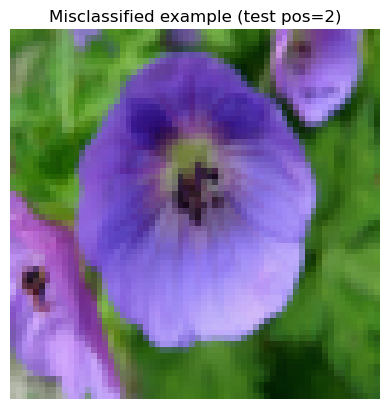

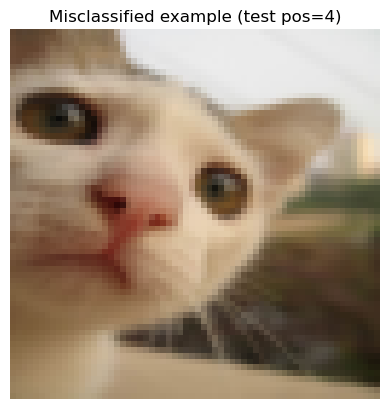

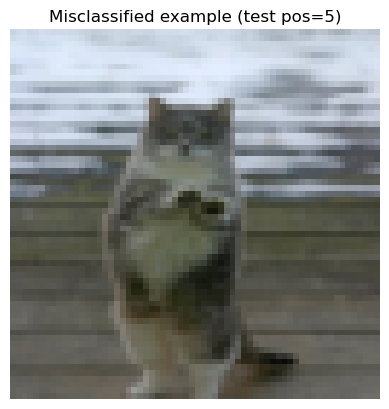

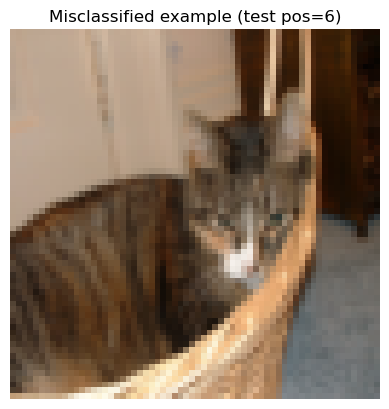

In [18]:
show = 4
for i in wrong_pos[:show]:
    img = X_orig[train_size + i]
    plt.imshow(img)
    plt.title(f"Misclassified example (test pos={i})")
    plt.axis('off')
    plt.show()


## The implemented neural network using only NumPy and PyTorch shows high training performance (≈99% accuracy) but significantly lower test accuracy (≈55%), indicating strong model overfitting and limited generalization ability. These observations imply that a deeper or better-regularized non-linear model would be required for real-world image classification tasks where feature complexity is high.